In [1]:
import numpy as np
import matplotlib.pyplot as plt
#kinetic monte-carlo imports
from simple_lattice_simulation import *


import sys
sys.path.append('/home/hcleroy/PostDoc/active_phase_separation/Steady_State_Numerical/')

import sparse_stoch_mat_central as sp_stoch_mat
from functions import *


# -----------------------------------------------------------------------------
# KMCLib version 2.0-a1
# Distributed under the GPLv3 license
# Copyright (C)  2012-2016  Mikael Leetmaa
# Developed by Mikael Leetmaa <leetmaa@kth.se>
#
# This program is distributed in the hope that it will be useful
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# LICENSE and README files, and the source code, for details.
#
# You should have received a copy of the GNU General Public License version 3
# (GPLv3) along with this program. If not, see <http://www.gnu.org/licenses/>.
# -----------------------------------------------------------------------------



/home/hcleroy/anaconda3/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/hcleroy/anaconda3/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/hcleroy/anaconda3/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/hcleroy/anaconda3/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


# Comparison between stochastic matrix diagonalization and KMC simulation
## Parameter space:
### Probability density formulation
The master equation that controls the probability distribution as used in the stochastic matrix solution writes :
$$ 
\begin{cases}
&\partial_t \rho_a = \partial_x^2 \rho_a +\partial_x[\rho_a \partial_x V_a] + \rho_b k_{ba} + \rho_c k_{ca} - \rho_a(k_{ac}+k_{ab})\\
&\partial_t \rho_b = \partial_x^2 \rho_b +\partial_x[\rho_b \partial_x V_b] + \rho_a k_{ab} + \rho_c k_{cb} - \rho_b(k_{bc}+k_{ba})\\
&\partial_t \rho_c = \partial_x^2 \rho_c +\partial_x[\rho_c \partial_x V_c] + \rho_a k_{ac} + \rho_b k_{bc} - \rho_c(k_{ca}+k_{cb})\\
\end{cases}
$$
with
$$
\begin{cases}
&k_{ab} =  e^{V_{AB}-V_A} \hspace{1cm} k_{bc} = k_{bc}^0e^{V_{BC}-V_B} \hspace{1cm} k_{ac} = k_{ac}^0 e^{V_{AC}-V_A}\\
&k_{ba} =  e^{V_{AB}-V_B} \hspace{1cm} k_{cb} = k_{bc}^0e^{V_{BC}-V_C} \hspace{1cm} k_{ca} = k_{ac}^0 e^{V_{AC}+V_C}
\end{cases}
$$
with
$$
\begin{aligned}
&V_A(x) = V_A^0/2(1 + \tanh(S_A x)) \\
&V_B(x) = V_B^0/2(1 + \tanh(S_B x)) \\
&V_C(x) = V_C^0/2(1 + \tanh(S_C x)) \\
&V_{AB}(x) = max(V_A(x),V_B(x))+\epsilon_{AB} \\
&V_{AC}(x) = max(V_A(x),V_C(x))+\epsilon_{AC} \\
&V_{BC}(x) = max(V_B(x),V_C(x))+\epsilon_{BC} \\
\end{aligned}
$$
The only free parameters are $k_{bc}^0$, $k_{ac}^0$, $V_A^0$, $V_B^0$, $V_C^0$, $S_A$, $S_B$, $S_C$, $\epsilon_{AB}$, $\epsilon_{AC}$, $\epsilon_{BC}$
### Langevin like dynamic
In the kinetic Monte Carlo simulation, the particles undergo a Langevin-like dynamic in a discrete space. The chemical transition rate is the same as in the probability density formulation, but the diffusion occurs differently. At each timestep, a particle can hop to the left or right with a probability that is consistent with the Fokker-Planck equation. This hopping has an intrinsic rate of $k_\text{diff}^0$ and results in a displacement of $\text{d}x$ (which is fixed at 1). We can show (see Léa's computation) :
$$
D = 2\text{d}x^2k_\text{diff}^0
$$
Thus, $k_\text{diff}^0$ is not a free parameter and should be set to 0.5.


In [11]:
# Common Parameters :
size = 10
VA0,VB0,VC0 = 0.5,1.,2.
steepA,steepB,steepC = .5,.5,.5
Eab,Ebc,Eac = 0.,0.,0.
Aab,Abc,Aac = 10.,1.,1.
va = lambda x : VA0/2*(1+np.tanh((x-size/2)*steepA))
vb = lambda x : VB0/2*(1+np.tanh((x-size/2)*steepB))
vc = lambda x : VC0/2*(1+np.tanh((x-size/2)*steepC))

#va = lambda x : 1. if x < size//2 else 0.
#vb = lambda x : 0. if x < size//2 else 1.
#vc = lambda x : 1. if x < size//2 else 0.
# define all the Vs :
def VA(X):
    try:
        if X.shape[0] == 3:
            return va(X[0])
        else:
            raise ValueError
    except:
        return va(X)
def VB(X):
    try:
        if X.shape[0] == 3:
            return vb(X[0])
        else:
            raise ValueError
    except:
        return vb(X)
def VC(X):
    try:
        if X.shape[0] == 3:
            return vc(X[0])
        else:
            raise ValueError
    except:
        return vc(X)

# The following expression of VAB,VAC,VBC should lead to the same rate than fixed relative barrier
VAB= lambda X: Eab+max(VA(X),VB(X))
VAC= lambda X: Eac+max(VC(X),VA(X))
VBC= lambda X: Ebc+max(VB(X),VC(X))
kbc0,kac0 = 1.,1.

# stochastic matrix parameters :
X0,Xf,n = 0,size,10000 # lower/higher spacial boundary and number of discretizing points
dx = (Xf-X0)/n
print('dx_{SM} = '+str(dx))

kab0=1. # !!!!!!!!!!! this is not an adjustable parameter !!!!!!!!!!!!!!!!!
kab = lambda X,*arg : np.array([kab0 * np.exp(-(VAB(x)-VA(x)))*arg[0] for x in X]) if type(X) == np.ndarray else kab0 * np.exp(-(VAB(X)-VA(X)))*arg[0] # arg is the activity
kba = lambda X,*arg : np.array([kab0 * np.exp(-(VAB(x)-VB(x)))for x in X]) if type(X)==np.ndarray else kab0 * np.exp(-(VAB(X)-VB(X)))# no activity but it takes the same argument as kab
kbc = lambda X,*arg : np.array([kbc0 * np.exp(-(VBC(x)-VB(x)))*arg[0]for x in X]) if type(X)==np.ndarray else kbc0 * np.exp(-(VBC(X)-VB(X)))*arg[0]# arg is the activity
kcb = lambda X,*arg : np.array([kbc0 * np.exp(-(VBC(x)-VC(x)))for x in X]) if type(X) == np.ndarray else kbc0 * np.exp(-(VBC(X)-VC(X)))# no activity but it takes the same argument as kbc
kac = lambda X,*arg : np.array([kac0 * np.exp(-(VAC(x)-VA(x)))*arg[0]for x in X]) if type(X) ==np.ndarray else kac0 * np.exp(-(VAC(X)-VA(X)))*arg[0]# arg is the activity
kca = lambda X,*arg : np.array([kac0 * np.exp(-(VAC(x)-VC(x)))for x in X]) if type(X) == np.ndarray else kac0 * np.exp(-(VAC(X)-VC(X)))# no activity but it takes the same argument as kac

# KMC simulation parameters :
Nparticles = 1
step_tot = 100000
dump_interval = max(1,step_tot//10)
analysis_interval = 1

dx_{SM} = 0.001


## Perform the kinetic Monte-Carlo simulation

In [12]:

OneDSim = OneDSimulation(size)
#OneDSim.set_up_config(Nparticles)
types = ['S']*size
types[0]='A'
#types[1]='B'
#types[2]='C'
OneDSim.set_up_specific_config(types,Nparticles=Nparticles)
OneDSim.set_up_interactions(VA,VB,VC,VAB,VAC,VBC,kac0,kbc0,Aab,Aac,Abc)
OneDSim.set_up_model()


In [13]:
OneDSim.RUN(step_tot,dump_interval,analysis_interval)

 KMCLib: setting up the backend C++ object.
 KMCLib: Runing for 100000 steps, starting from time: 0.000000

 KMCLib: 10000 steps executed. time:     2.3045346926e+03 
 KMCLib: 20000 steps executed. time:     4.6126635275e+03 
 KMCLib: 30000 steps executed. time:     6.9116962210e+03 
 KMCLib: 40000 steps executed. time:     9.2089318705e+03 
 KMCLib: 50000 steps executed. time:     1.1503504335e+04 
 KMCLib: 60000 steps executed. time:     1.3765019649e+04 
 KMCLib: 70000 steps executed. time:     1.6058463890e+04 
 KMCLib: 80000 steps executed. time:     1.8382456796e+04 
 KMCLib: 90000 steps executed. time:     2.0735913907e+04 
 KMCLib: 100000 steps executed. time:     2.3082365168e+04 
execution time : 23.14346564800144


## Do the same with the stochastic matrix

In [14]:
Eq_Stoch_Mat = sp_stoch_mat.make_transition_matrix(VA,VB,VC,
                                    kab,kba,kbc,kcb,kac,kca,
                                    kab0,kbc0,kac0,
                                    Aab=Aab,Abc=Abc,Aac=Aac,
                                    X0=X0,Xf=Xf,n=n)
rho_a_mat,rho_b_mat,rho_c_mat = get_kernel_stoch_mat(Eq_Stoch_Mat,dx)

## Compute the stat mech density profile

In [15]:
rhoa_stat_mech = np.exp(-VA(np.linspace(X0,Xf,n,endpoint=False)))
#rhoa_stat_mech = rhoa_stat_mech/sum(rhoa_stat_mech*dx)
rhob_stat_mech = np.exp(-VB(np.linspace(X0,Xf,n,endpoint=False)))
rhoc_stat_mech = np.exp(-VC(np.linspace(X0,Xf,n,endpoint=False)))
SUM = sum(rhoa_stat_mech*dx)+sum(rhob_stat_mech*dx)+sum(rhoc_stat_mech*dx)
rhoa_stat_mech,rhob_stat_mech,rhoc_stat_mech = rhoa_stat_mech/SUM,rhob_stat_mech/SUM,rhoc_stat_mech/SUM

#SUM = sum(rhoa_stat_mech*dx)+sum(rhob_stat_mech*dx)
#rhoa_stat_mech,rhob_stat_mech = rhoa_stat_mech/SUM,rhob_stat_mech/SUM

## Plot both results

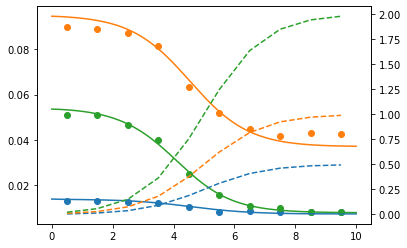

In [16]:
X,rhois = OneDSim.get_density_profile()

fig,ax = plt.subplots()
ax.scatter(X,rhois[0])
ax.scatter(X,rhois[1])
ax.scatter(X,rhois[2])

X_stoch_mat = np.linspace(X0,Xf,n,endpoint=False)
ax.plot(X_stoch_mat,rho_a_mat)
ax.plot(X_stoch_mat,rho_b_mat)
ax.plot(X_stoch_mat,rho_c_mat)
#ax.plot(X_stoch_mat,rhoa_stat_mech)
#ax.plot(X_stoch_mat,rhob_stat_mech)
#ax.plot(X_stoch_mat,rhoc_stat_mech)


ax2 = ax.twinx()
ax2.plot(X,VA(X),linestyle='--')
ax2.plot(X,VB(X),linestyle='--')
ax2.plot(X,VC(X),linestyle='--')

## Compare the flux

In [17]:
X_sim,phis = OneDSim.get_diffusive_flux()

In [18]:
A_diff_flux = diff_flux(rho_a_mat,VA(np.linspace(X0,Xf,n,endpoint=False)),dx)
B_diff_flux = diff_flux(rho_b_mat,VB(np.linspace(X0,Xf,n,endpoint=False)),dx)
C_diff_flux = diff_flux(rho_c_mat,VC(np.linspace(X0,Xf,n,endpoint=False)),dx)

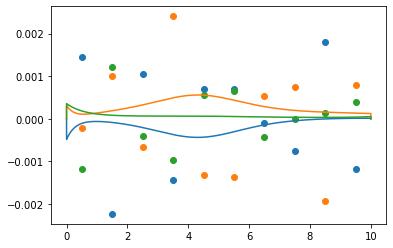

In [19]:
plt.scatter(X_sim,phis['A'])
plt.scatter(X_sim,phis['B'])
plt.scatter(X_sim,phis['C'])

plt.plot(np.linspace(X0,Xf,n,endpoint=False),A_diff_flux)
plt.plot(np.linspace(X0,Xf,n,endpoint=False),B_diff_flux)
plt.plot(np.linspace(X0,Xf,n,endpoint=False),C_diff_flux)